# DQN single asset : BTC

### Settings

In [1]:
import sys
external_pkgs_paths = [r".\external_pkgs\gym-0.18.3\gym-0.18.3"]
for path in external_pkgs_paths:
    if path not in sys.path:
        sys.path.insert(0, path) 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Import (if not yet)

In [2]:
# !pip install datatable
# !pip install sympy
# !pip install pyyaml
# !pip install tqdm
# !pip install tensorflow

In [3]:
# import necessary modules
import ta
from functools import reduce
import pandas as pd
import gc
import pickle
import tensortrade as td
from pathlib import Path 
import datatable as dt

from tensortrade.exchanges import Exchange
from tensortrade.instruments import Instrument, CNY, USD
from tensortrade.wallets import Wallet, Portfolio
from tensortrade.exchanges.services.execution.simulated import execute_order
from tensortrade.data import Stream, Module, DataFeed
from tensortrade.data import DataFeed, Module

# In[deploy network api]:
import tensorflow as tf
# In[deploy action schemes]:
from MoneyPositionScheme import * 
# In[deploy reward schemes]:
from RelativeReturnReward import RelativeReturnReward
# In[create environment]:
from tensortrade.environments import TradingEnvironment
# In[import agent]:
from tensortrade.agents import DQNAgent

## Get data

### 1. Get signals 

In [4]:
filepath = Path('../signals/csv/rl_signals_selected.csv')
df_signals = dt.fread(filepath).to_pandas()
df_signals = df_signals.set_index('date')*1
df_signals.index = pd.to_datetime(df_signals.index).strftime('%Y-%m-%d %H:%M:%S')
df_signals.tail(3)

,OpenInterest,glassnode_f4,wavelet_clf,condition_BBW,condition_Vol,strat_BB,strat_MACD,strat_HH_LL,combine_strat_cond,HMM_detected_regime,fng_classification
date,,,,,,,,,,,
2022-04-04 22:00:00,8.812256,0.0,1,1,1,1,1,0,0,0,0.0
2022-04-04 23:00:00,8.812256,0.0,1,1,1,0,1,0,0,0,0.0
2022-04-05 00:00:00,8.877873,0.0,1,1,1,0,1,0,0,0,0.0


### 2. Get BTC close price

In [5]:
filepath = Path('../data/csv/crypto_market_data.csv')
# Get crypto data
df_crypto = dt.fread(filepath).to_pandas() 
df_crypto = df_crypto.T.set_index([0, 1]).T
df_crypto = df_crypto.set_index('')
df_crypto = df_crypto.astype(float)
df_crypto.index.names = ['date']
# Get the daily return (on the close price of the BTC)
df_close = df_crypto.T.swaplevel(0, 1).T['Close']['BTC-USD']
df_close.index = pd.to_datetime(df_close.index)
df_close = df_close[df_close.index.hour == 23]
df_close.index = df_close.index.date
df_close.index = pd.to_datetime(df_close.index).strftime('%Y-%m-%d %H:%M:%S')
df_close = pd.DataFrame(df_close, index=df_close.index, columns=['BTC-USD'])
display(df_close.tail(3))

,BTC-USD
2022-04-04 00:00:00,46615.023438
2022-04-05 00:00:00,45553.027344
2022-04-06 00:00:00,43193.953125


## Get data ready for RL model

In [6]:
df = df_signals.join(df_close).dropna(axis=0)*1
df.index = pd.to_datetime(df.index)

In [7]:
display(df.shape, df.index.min(), df.index.max())
df.head(3)

(259, 12)

Timestamp('2021-04-01 00:00:00')

Timestamp('2022-04-05 00:00:00')

,OpenInterest,glassnode_f4,wavelet_clf,condition_BBW,condition_Vol,strat_BB,strat_MACD,strat_HH_LL,combine_strat_cond,HMM_detected_regime,fng_classification,BTC-USD
date,,,,,,,,,,,,
2021-04-01,10.533728,0.0,1,1,1,0,1,0,0,0,1.0,59306.312500
2021-04-03,11.082387,0.0,1,0,0,0,-1,0,0,0,1.0,58118.398438
2021-04-06,11.183291,0.0,1,1,1,0,1,0,0,0,1.0,58109.234375


#### Split data

In [8]:
train_data = df[df.index < "2022"]
test_data = df[df.index >= "2022"]

n_train, n_test = len(train_data), len(test_data)
print(f'Train : {n_train} ({int(n_train/(n_train+n_test)*100)}%)')
print(f'Test : {n_test} ({int(n_test/(n_train+n_test)*100)}%)')

Train : 168 (64%)
Test : 91 (35%)


## Reinforcement Learning Setup

### 1. Create Exchanges

In [9]:
BTC = Instrument('BTC', 2, 'Bintcoin')

config = {
    "base_instrument": USD,
    "instruments": [BTC]
}

with td.TradingContext(**config):
    exchange_name = 'train_data_exchange'
    train_data_exchange = Exchange(exchange_name, service=execute_order, timestamps=train_data.index.tolist())(
        Stream("-".join([BTC.symbol, USD.symbol]), list(train_data['BTC-USD']))
    )
train_data_exchange.build()
print(train_data_exchange._prices)

with td.TradingContext(**config):
    exchange_name = 'test_data_exchange'
    test_data_exchange = Exchange(exchange_name, service=execute_order, timestamps=test_data.index.tolist())(
        Stream("-".join([BTC.symbol, USD.symbol]), list(test_data['BTC-USD']))
    )
test_data_exchange.build()
print(test_data_exchange._prices)

{'BTC/USD': <Node: name=BTC-USD, type=forward>}
{'BTC/USD': <Node: name=BTC-USD, type=forward>}


### 2. Create the data feed

In [10]:
def create_feed(raw_data, module_name, colprefix="BTC", drop_raw=False, feature_list=None):
    
    feature_data = raw_data.copy(deep=True)
    colprefix = colprefix + "_"

    if drop_raw:
        num_raw_cols = feature_data.shape[1]
        feature_data = feature_data.iloc[:, num_raw_cols:]

    if feature_list is None:
        feature_list = feature_data.columns.tolist()
    else:
        feature_list = [colprefix + x for x in feature_list]

    with Module(module_name) as ns:
        for col in feature_list:
            ns = ns(Stream(col, list(feature_data[col])))
    feed = DataFeed([ns])
    return feed

In [11]:
train_close = train_data['BTC-USD']
test_close = test_data['BTC-USD']

train_data = train_data.drop(columns=['BTC-USD'])
test_data = test_data.drop(columns=['BTC-USD'])

In [12]:
train_feed = create_feed(raw_data=train_data, module_name="train", colprefix="BTC", drop_raw=False, feature_list=None)
test_feed = create_feed(raw_data=test_data, module_name="test", colprefix="BTC", drop_raw=False, feature_list=None)

In [13]:
#train_feed.next()
#test_feed.next()

In [14]:
print(f'# signals train: {len(train_feed.next())}')
print(f'# signals test: {len(test_feed.next())}')

# signals train: 11
# signals test: 11


### 3. Create portfolio

In [15]:
with td.TradingContext(**config):
    train_portfolio = Portfolio(USD, [
        Wallet(train_data_exchange, 100000 * USD),
        Wallet(train_data_exchange, 0 * BTC)
    ])

with td.TradingContext(**config):
    test_portfolio = Portfolio(USD, [
        Wallet(test_data_exchange, 100000 * USD),
        Wallet(test_data_exchange, 0 * BTC)
    ])

### 4. Create Environments for RL

In [16]:
train_Action = DiscretePositionScheme(positionList=np.arange(0, 0.91, 0.1).tolist())
test_Action = DiscretePositionScheme(positionList=np.arange(0, 0.91, 0.1).tolist())
relativeReward = RelativeReturnReward()
window_size = 10
max_episode_timesteps = 40
stochastic_reset = True

with td.TradingContext(**config):
    train_env = TradingEnvironment(portfolio=train_portfolio,
                                   reward_scheme=relativeReward,
                                   action_scheme=train_Action,
                                   max_episode_timesteps=max_episode_timesteps,
                                   external_feed=train_feed,
                                   window_size=window_size,
                                   observe_internal_feed=False,
                                   on_execute_verbose=False,
                                   stochastic_reset=stochastic_reset,
                                   clock_map=train_data.index.tolist())

    test_env = TradingEnvironment(portfolio=test_portfolio,
                                  reward_scheme=relativeReward,
                                  action_scheme=test_Action,
                                  max_episode_timesteps=max_episode_timesteps,
                                  external_feed=test_feed,
                                  window_size=window_size,
                                  observe_internal_feed=False,
                                  on_execute_verbose=False,
                                  stochastic_reset=stochastic_reset,
                                  clock_map=test_data.index.tolist())

# env.reset() 

### 4. Config network structure

In [17]:
# tf.reset_default_graph()
with tf.device(
        '/CPU:0'):  # tf2.3.will raise error if there are other tf GPU processes running on this device(maybe Chrome)
    network = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=train_env.observation_space.shape),
        tf.keras.layers.Conv1D(filters=5, kernel_size=5, padding="valid", activation="tanh"),  # horizontal filter
        # tf.keras.layers.MaxPooling1D(pool_size=3),
        tf.keras.layers.Conv1D(filters=4, kernel_size=5, padding="valid", activation="tanh"),
        # tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        # tf.keras.layers.Dense(128, activation="relu"),
        # tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(len(train_env.action_space), activation="relu")
    ])


In [18]:
train_env.observation_space.shape

(10, 11)

In [19]:
network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 6, 5)              280       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 4)              104       
_________________________________________________________________
flatten (Flatten)            (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 11)                99        
Total params: 483
Trainable params: 483
Non-trainable params: 0
_________________________________________________________________


In [20]:
agent_spec = {
    'discount_factor': 0.5,
    'learning_rate': 0.0001,
    'batch_size': 32,
    'eps_start': 1,
    'eps_end': 0.05,
    'eps_decay_steps': 20,
    'update_target_every': 100,
    'memory_capacity': 10000,
    "ini_steps": 512,
    "max_episode_timesteps": train_env.max_episode_timesteps}
save_path = r'.\models\train'
step_verbose = False
episode_verbose = False
n_episodes = 50
save_every = 5
evaluate_every_n_episode = 5
save_episodic_performance = False

## Train-Test model

### 1. Baseline: buy and hold

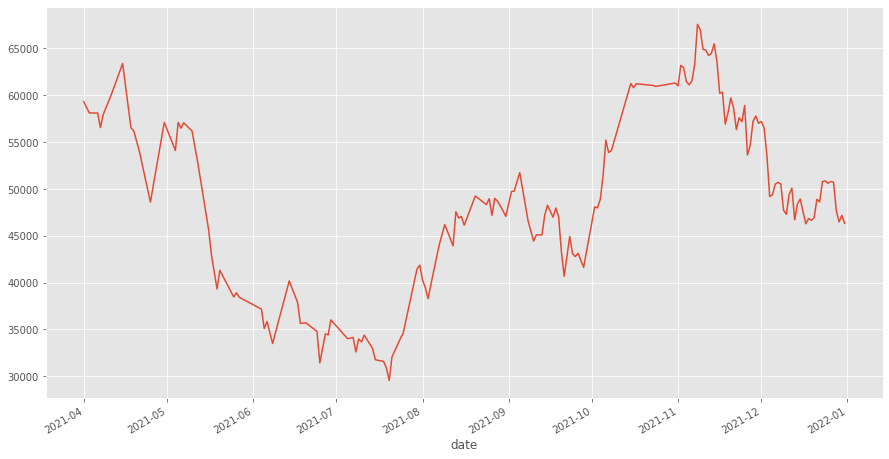

In [21]:
train_close.plot(figsize=(15,8))

### 2. Train RL agent

100%|██████████| 512/512 [00:03<00:00, 159.56it/s]


Start training...


  8%|▊         | 4/50 [00:03<00:34,  1.32it/s]

Evaluation after 5 episodes (158 steps) with average reward: -0.1473336572155919


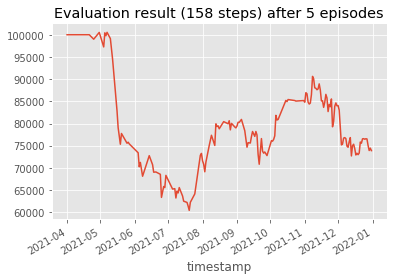

 18%|█▊        | 9/50 [00:07<00:33,  1.23it/s]

Evaluation after 10 episodes (158 steps) with average reward: 0.07631233358101328


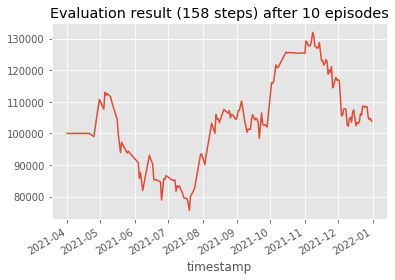

 28%|██▊       | 14/50 [00:12<00:29,  1.24it/s]

Evaluation after 15 episodes (158 steps) with average reward: -0.12506726831680642


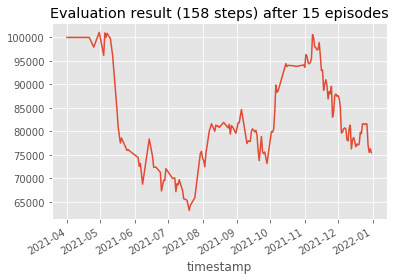

 38%|███▊      | 19/50 [00:17<00:27,  1.15it/s]

Evaluation after 20 episodes (158 steps) with average reward: 0.11855866075939689


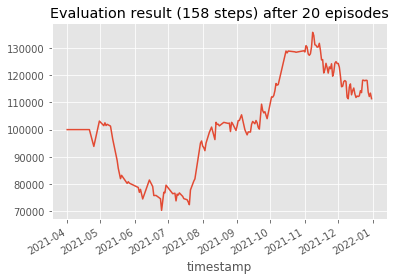

 48%|████▊     | 24/50 [00:21<00:21,  1.22it/s]

Evaluation after 25 episodes (158 steps) with average reward: 0.056189461920256735


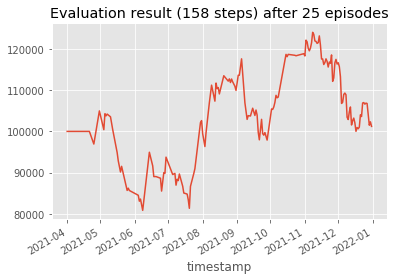

 58%|█████▊    | 29/50 [00:26<00:18,  1.15it/s]

Evaluation after 30 episodes (158 steps) with average reward: 0.03843395055608321


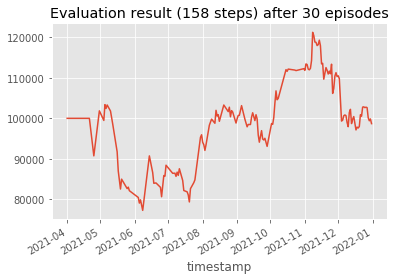

 68%|██████▊   | 34/50 [00:31<00:13,  1.15it/s]

Evaluation after 35 episodes (158 steps) with average reward: -0.13794523587886104


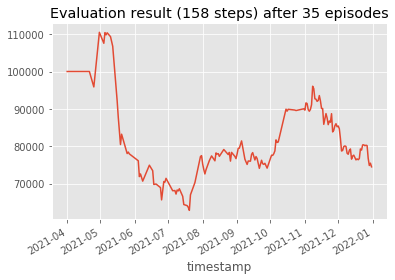

 78%|███████▊  | 39/50 [00:36<00:08,  1.22it/s]

Evaluation after 40 episodes (158 steps) with average reward: -0.0017887025420859287


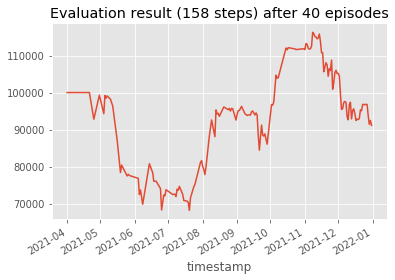

 88%|████████▊ | 44/50 [00:40<00:05,  1.17it/s]

Evaluation after 45 episodes (158 steps) with average reward: -0.01931969882241113


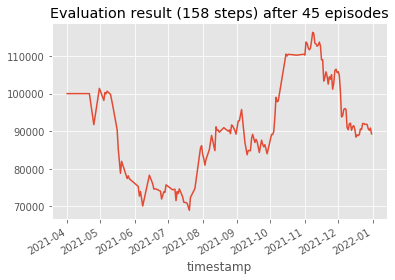

 98%|█████████▊| 49/50 [00:45<00:00,  1.11it/s]

Evaluation after 50 episodes (158 steps) with average reward: 0.10526159640323571


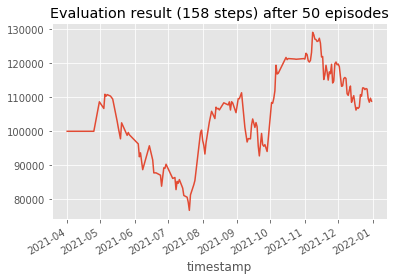

100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


In [22]:
with tf.device('/CPU:0'):
    myAgent = DQNAgent(train_env, policy_network=network)
    myAgent.train(n_episodes=n_episodes,
                  save_every=save_every,
                  save_path=save_path,
                  step_verbose=step_verbose,
                  episode_verbose=episode_verbose,
                  evaluate_every_n_episode=evaluate_every_n_episode,
                  save_episodic_performance=save_episodic_performance,
                  **agent_spec)

### 3. Restore RL agent

In [23]:
with tf.device('/CPU:0'):
    myAgent = DQNAgent(train_env, policy_network=network)

In [ ]:
# the last number for the .h5 is the number of epsiode trained (you need to make sure the following path exists!!)
#myAgent.restore("./models/train/policy_network__a13bf913-f3f2-4077-8620-bda9693b0899__35.h5")  

### 4. Test over different data sets (environments)

100%|██████████| 40/40 [00:00<00:00, 183.68it/s]


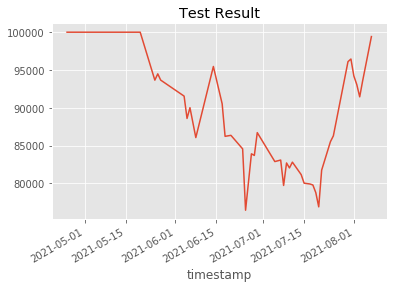

Annual Sharpe: -0.256991990381263
Maximum drop down: 0.2829278699259451
Cumulative return(single-rate): -0.03164527620183212
Cumulative return(compound-rate) : -0.00577718242187486


In [24]:
with tf.device('/CPU:0'):
    myAgent.env = train_env  # set the environment you want to test
    myAgent.test(start_step = 10, n_steps=40) # make sure you won't exceed the maximum length of the data feed in the envirnoment

100%|██████████| 40/40 [00:00<00:00, 181.67it/s]


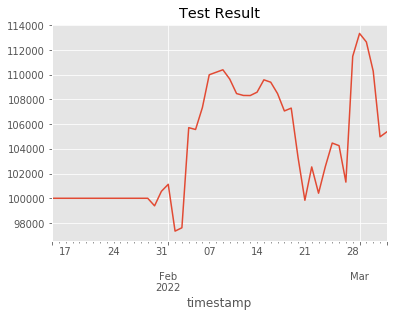

Annual Sharpe: -0.8825985575662482
Maximum drop down: 0.16364787255927904
Cumulative return(single-rate): -0.06613279899912654
Cumulative return(compound-rate) : 0.05375218632812495


In [25]:
with tf.device('/CPU:0'):
    myAgent.env = test_env  # set the environment you want to test
    myAgent.test(start_step = 10, n_steps=40)  # make sure you won't exceed the maximum length of the data feed in the envirnoment

### 5. Compare with baseline performance

In [26]:
def max_dropdown(series):
    _acc = series.cumsum().tolist()
    _max = -np.inf
    max_dd = 0

    for _val in _acc:
        _max = max(_max, _val)
        max_dd = max(max_dd, _max - _val)
    return max_dd

import matplotlib.pyplot as plt
def get_baseline_metrics(price):
    
    price.plot(figsize=(15,8), title="BTC(test set)")
    plt.show()
    ret = price.diff(-1) / price
    sharpe = np.sqrt(252) * ret.mean() / ret.std()
    mdd = max_dropdown(ret)
    cum_ret = ret.sum()

    print("Annual Sharpe: {}".format(sharpe))
    print("Maximum drop down: {}".format(mdd))
    print("Cumulative return(single-rate): {}".format(cum_ret))
    print("Cumulative return(compound-rate) : {}".format(price.iloc[-1]/price.iloc[0] - 1))

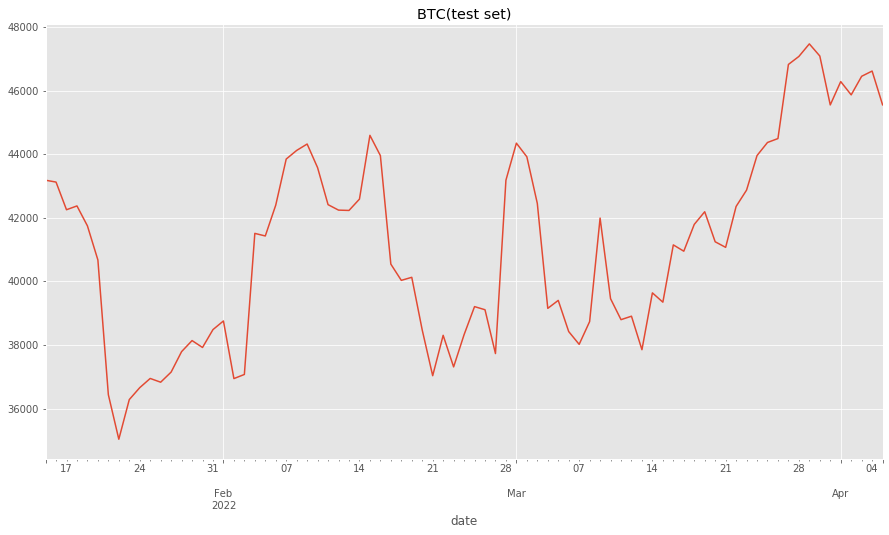

Annual Sharpe: -0.5725278360423811
Maximum drop down: 0.34723928591206077
Cumulative return(single-rate): -0.10530043177462037
Cumulative return(compound-rate) : 0.05492571105597377


In [27]:
price = test_close.iloc[10:]
get_baseline_metrics(price)

### 6. Show the action history while testing

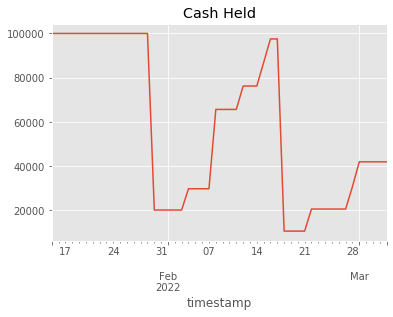

In [28]:
test_env.portfolio.performance["test_data_exchange:/USD:/free"].iloc[10:].plot(title="Cash Held")

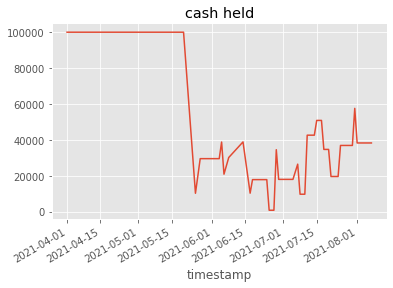

In [29]:
train_env.portfolio.performance["train_data_exchange:/USD:/free"].plot(title="cash held")